# POC and CPhyto Notebook

Authors: Paul Lerner

In [2]:
import csv
import os

import cartopy.crs as ccrs
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import dask.array as da
from   dask.distributed import Client
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import matplotlib
import matplotlib.colors as colors
from matplotlib import lines
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker 
import cartopy.mpl.ticker as cticker
import pandas as pd
from matplotlib.widgets import TextBox
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA



# first login to EarthAccess

In [3]:
auth = earthaccess.login()
# are we authenticated?
if auth.authenticated:
    print("authenticated!")
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

authenticated!


In [260]:
results = earthaccess.search_datasets(instrument="oci")

In [261]:
for item in results:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L1B_SCI
PACE_OCI_L2_AOP
PACE_OCI_L2_BGC_NRT
PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_BGC
PACE_OCI_L2_CLOUD
PACE_OCI_L2_CLOUD_MASK
PACE_OCI_L2_CLOUD_MASK_NRT
PACE_OCI_L2_CLOUD_NRT
PACE_OCI_L2_IOP
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_LANDVI
PACE_OCI_L2_LANDVI_NRT
PACE_OCI_L2_PAR
PACE_OCI_L2_PAR_NRT
PACE_OCI_L2_SFREFL
PACE_OCI_L2_SFREFL_NRT
PACE_OCI_L3B_AVW
PACE_OCI_L3B_AVW_NRT
PACE_OCI_L3B_CARBON
PACE_OCI_L3B_CARBON_NRT
PACE_OCI_L3B_CHL
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_FLH
PACE_OCI_L3B_FLH_NRT
PACE_OCI_L3B_IOP
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_KD
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_LANDVI
PACE_OCI_L3B_LANDVI_NRT
PACE_OCI_L3B_PAR
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_POC
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_RRS
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3B_SFREFL
PACE_OCI_L3B_SFREFL_NRT
PACE_OCI_L3M_AVW
PACE_OCI_L3M_AVW_NRT
PACE_OCI_L3M_CARBON
PACE_OCI_L3M_CARBON_NRT
PACE_OCI_L3M_CHL
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L3M_CLOUD
PACE_OCI_L3M_CLOUD_NRT
PACE_OCI_L3M_FLH
PA

In [520]:
lon_min = -75
lon_max = 15
lat_min = -30
lat_max = 60
tspan = ("2024-04-02", "2025-08-31")
bbox = (lon_min, lat_min, lon_max, lat_max)

# This function is for if you want to normalize your dataset

In [521]:
def normalize_phy_dataset(ds, variables=None):
    ds = ds.astype(np.float64)
    
    # Min-max normalization
    norm = (ds - ds.min()) / (ds.max() - ds.min())
    
    # Convert to DataArray (stacked along 'variable' dim)
    data_norm = norm.to_array("variable")

    # filter variables
    if variables is not None:
        data_norm = data_norm.sel(variable=variables)
    
    return data_norm

# Let's start with processing the data

In [574]:
results_cphyto = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CARBON",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*.0p1deg.*",
)
results_poc = earthaccess.search_data(
    short_name="PACE_OCI_L3M_POC",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*.0p1deg.*",
)
results_chl = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*.0p1deg.*",
)


In [575]:
paths_cphyto = earthaccess.open(results_cphyto)
paths_poc = earthaccess.open(results_poc)
paths_chl = earthaccess.open(results_chl)


QUEUEING TASKS | :   0%|          | 0/386 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/386 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/386 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/386 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/386 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/386 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/386 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/386 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/386 [00:00<?, ?it/s]

In [527]:
def time_from_attr(ds):
    """Set the time attribute as a dataset variable
    Args:
        ds: a dataset corresponding to one or multiple Level-2 granules
    Returns:
        the dataset with a scalar "time" coordinate
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["date"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("date")
    return ds


In [576]:
dataset = xr.open_mfdataset(
    paths_cphyto, preprocess=time_from_attr, combine="nested", concat_dim="date"
)
dataset_POC = xr.open_mfdataset(
    paths_poc, preprocess=time_from_attr, combine="nested", concat_dim="date"
)
dataset_chl = xr.open_mfdataset(
    paths_chl, preprocess=time_from_attr, combine="nested", concat_dim="date"
)



In [584]:
dataset_bgc = xr.merge([dataset,dataset_POC,dataset_chl])

In [589]:
dataset_bgc = dataset.drop_vars(["palette"])


ValueError: These variables cannot be found in this dataset: ['palette']

In [592]:
dataset_bgc["carbon_phyto"] = dataset_bgc["carbon_phyto"].clip(
    min=dataset_bgc["carbon_phyto"].attrs["valid_min"],
    max=dataset_bgc["carbon_phyto"].attrs["valid_max"],
)
dataset_bgc["chlor_a"] = dataset_bgc["chlor_a"].clip(
    min=dataset_bgc["chlor_a"].attrs["valid_min"],
    max=dataset_bgc["chlor_a"].attrs["valid_max"],
)

In [544]:
#dataset_cphyto_data = dataset.sel(lon=slice(-75,15)).compute()


# Monthly Stats Extraction (Code Below this point largely from Olivia)

In [599]:
# Compute monthly stats
mean_bgc_ds = dataset_bgc.resample(date="1M").mean("date")
median_bgc_ds = dataset_bgc.resample(date="1M").median("date")
std_bgc_ds = dataset_bgc.resample(date="1M").std("date")
count_bgc_ds = dataset_bgc.resample(date="1M").count("date")

# Compute CV 
cv_bgc_ds = std_bgc_ds / mean_bgc_ds

# Access Lat/lon Data

In [600]:
# Load and deduplicate lat/lon points
points_df = pd.read_csv("../AMT28_underway_latlon.csv").drop_duplicates(subset=["Lat", "Lon"]).reset_index(drop=True)
points_df["point"] = np.arange(len(points_df))

# Create point-indexed lat/lon DataArrays
lat_da = xr.DataArray(points_df["Lat"].values, dims="point")
lon_da = xr.DataArray(points_df["Lon"].values, dims="point")

# Extract stats a co-lated AMT points

In [606]:
# unnormalized
mean_da   = mean_bgc_ds.to_array("variable")
median_da = median_bgc_ds.to_array("variable")
std_da    = std_bgc_ds.to_array("variable")
cv_da     = cv_bgc_ds.to_array("variable")

unnorm_layers = {
    "mean": mean_da,
    "median": median_da,
    "std": std_da,
    "cv": cv_da,
}


In [607]:
# List of shared stats
stat_names = list(unnorm_layers.keys())

In [608]:
def extract_group(group_name, norm_layers, lat_da, lon_da, points_df):
    """
    Extract all stats for one phytoplankton group using nearest-neighbor selection.
    Returns a long-form DataFrame.
    """
    records = []
    
    for stat_name, da_stat in norm_layers.items():
        print(f"Extracting {group_name} - {stat_name}")
        
        da = da_stat.sel(variable=group_name)

        # Vectorized nearest-neighbor selection across (date, point)
        interp = da.sel(lat=lat_da, lon=lon_da, method="nearest").compute()

        # Result dims: (date, point) → convert to long-form
        df = interp.to_dataframe(name="value").reset_index()

        # Merge back lat/lon
        df = df.merge(points_df, on="point")[["date", "Lat", "Lon", "value"]]
        df["stat"] = stat_name
        df["variable"] = group_name

        records.append(df)

    return pd.concat(records, ignore_index=True)

In [609]:
#Extract unnormalized data
df_phytoc = extract_group("carbon_phyto", unnorm_layers, lat_da, lon_da, points_df)
df_poc = extract_group("poc", unnorm_layers, lat_da, lon_da, points_df)
df_chla = extract_group("chlor_a", unnorm_layers, lat_da, lon_da, points_df)


Extracting carbon_phyto - mean
Extracting carbon_phyto - median
Extracting carbon_phyto - std
Extracting carbon_phyto - cv
Extracting poc - mean
Extracting poc - median
Extracting poc - std
Extracting poc - cv
Extracting chlor_a - mean
Extracting chlor_a - median
Extracting chlor_a - std
Extracting chlor_a - cv


# Organize and Export Tables

In [610]:
# Add month-year label for plotting
df_phytoc["date"] = df_phytoc["date"].dt.strftime("%b %Y")
df_poc["date"] = df_poc["date"].dt.strftime("%b %Y")
df_chla["date"] = df_chla["date"].dt.strftime("%b %Y")

# Rename column
df_phytoc.rename(columns={'date': 'month_year'}, inplace=True)
df_poc.rename(columns={'date': 'month_year'}, inplace=True)
df_chla.rename(columns={'date': 'month_year'}, inplace=True)


In [611]:
# Add month-year label for plotting
df_phytoc_wide = df_phytoc.pivot_table(
    index=["month_year", "Lat", "Lon"],
    columns="stat",
    values="value"
).reset_index()

df_phytoc_wide["value"] = "phyto carbon"
#poc
df_poc_wide = df_poc.pivot_table(
    index=["month_year", "Lat", "Lon"],
    columns="stat",
    values="value"
).reset_index()

df_poc_wide["value"] = "poc"
# chl
df_chla_wide = df_chla.pivot_table(
    index=["month_year", "Lat", "Lon"],
    columns="stat",
    values="value"
).reset_index()

df_chla_wide["value"] = "chlor_a"




# Now we need to find where the BGC and MOANA Tables intersect

In [667]:
# Load MOANA-AMT "matchup
df_moana = pd.read_csv("../Olivia/Tables/picoeuk_monthly_stats_unnormalized.csv")
keys = ['month_year','Lat', 'Lon']
keys2 = ['month_year','Lat', 'Lon','cv_y','mean_y','median_y','std_y','value_y']
intersection_phyto_c = df_phytoc_wide.merge(df_moana[keys], on=keys)
intersection_poc = df_poc_wide.merge(df_moana[keys], on=keys)
intersection_chla = df_chla_wide.merge(df_moana[keys], on=keys)
intersection_chla = pd.merge(df_moana,intersection_chla, on=keys, how='inner')
intersection_chla = intersection_chla[keys2]
intersection_chla = intersection_chla.rename(columns={"cv_y": "cv", "mean_y": "mean","median_y": "median","std_y": "std","value_y": "value"})
intersection_phyto_c = pd.merge(df_moana,intersection_phyto_c, on=keys, how='inner')
intersection_phyto_c = intersection_phyto_c[keys2]
intersection_phyto_c = intersection_phyto_c.rename(columns={"cv_y": "cv", "mean_y": "mean","median_y": "median","std_y": "std","value_y": "value"})
intersection_poc = pd.merge(df_moana,intersection_poc, on=keys, how='inner')
intersection_poc = intersection_poc[keys2]
intersection_poc = intersection_poc.rename(columns={"cv_y": "cv", "mean_y": "mean","median_y": "median","std_y": "std","value_y": "value"})

intersection_poc.to_csv("Tables/poc_monthly_stats_unnormalized.csv", index=False)
intersection_chla.to_csv("Tables/chla_monthly_stats_unnormalized.csv", index=False)
intersection_phyto_c.to_csv("Tables/phyto_carbon_monthly_stats_unnormalized.csv", index=False)

In [4]:
df = pd.read_csv('Tables/poc_monthly_stats_unnormalized.csv')
df = df.rename(columns={"cv_y": "cv", "mean_y": "mean","median_y": "median","std_y": "std","value_y": "value"})
df.to_csv("Tables/poc_monthly_stats_unnormalized.csv", index=False)

df = pd.read_csv('Tables/phto_carbon_monthly_stats_unnormalized.csv')
df = df.rename(columns={"cv_y": "cv", "mean_y": "mean","median_y": "median","std_y": "std","value_y": "value"})
df.to_csv("Tables/phyto_carbon_monthly_stats_unnormalized.csv", index=False)

df = pd.read_csv('Tables/chla_monthly_stats_unnormalized.csv')
df = df.rename(columns={"cv_y": "cv", "mean_y": "mean","median_y": "median","std_y": "std","value_y": "value"})
df.to_csv("Tables/chla_monthly_stats_unnormalized.csv", index=False)

In [5]:
df

,month_year,Lat,Lon,cv,mean,median,std,value
0,Apr 2024,-48.199,-52.692,0.117412,0.357765,0.338076,0.042006,chlor_a
1,Apr 2024,-48.115,-52.572,0.087586,0.366482,0.360107,0.032099,chlor_a
2,Apr 2024,-48.014,-52.436,0.160421,0.391770,0.375639,0.062848,chlor_a
3,Apr 2024,-47.933,-52.353,0.178919,0.379481,0.334546,0.067896,chlor_a
4,Apr 2024,-47.860,-52.236,0.212918,0.365566,0.372546,0.077835,chlor_a
...,...,...,...,...,...,...,...,...
8927,Sep 2024,11.790,-27.795,0.068735,0.139984,0.142469,0.009622,chlor_a
8928,Sep 2024,11.976,-27.841,0.136587,0.137541,0.137541,0.018786,chlor_a
8929,Sep 2024,12.355,-27.937,0.151994,0.145452,0.159962,0.022108,chlor_a
8930,Sep 2024,6.256,-26.381,0.000000,0.173372,0.173372,0.000000,chlor_a


# Now create some maps

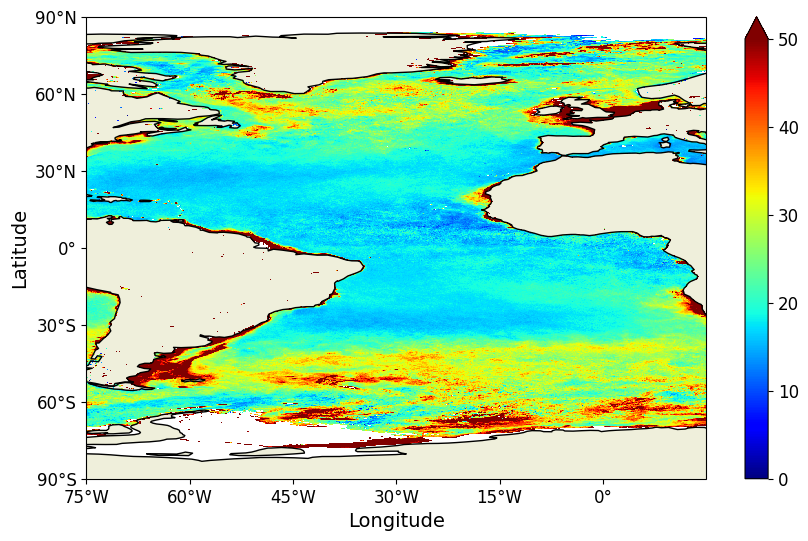

In [672]:
# plot phytoplankton carbonn
lbs = 12
xyfs = 14
mapn = colors.Normalize(vmin=0, vmax=50)
#colors.LogNorm(vmin=0.001, vmax=0.1)
fig = plt.figure(figsize=(10,6))
axs = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(), aspect='auto')
#dataset_cphyto_data = dataset.sel(lon=slice(-75,15)).compute()

im=dataset_bgc['carbon_phyto'].sel(lon=slice(-75,15)).mean(dim='date').plot(ax=axs,cmap='jet',norm = mapn,transform=ccrs.PlateCarree())
axs.add_feature(cartopy.feature.LAND)
axs.add_feature(cartopy.feature.COASTLINE)
cbar = im.colorbar
cbar.set_label('')
cbar.ax.tick_params(labelsize=lbs)

axs.set_title('')
axs.set_ylabel('Latitude',fontsize=xyfs)
axs.set_xlabel('Longitude',fontsize=xyfs)
axs.set_xticks(np.arange(-75,15,15), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)

axs.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter)
axs.tick_params(axis='both', which='major', labelsize=lbs)
axs.tick_params(axis='both', which='minor', labelsize=lbs)
plt.show()

**How much data do we have?**

max number of datapoints per grid cell =357


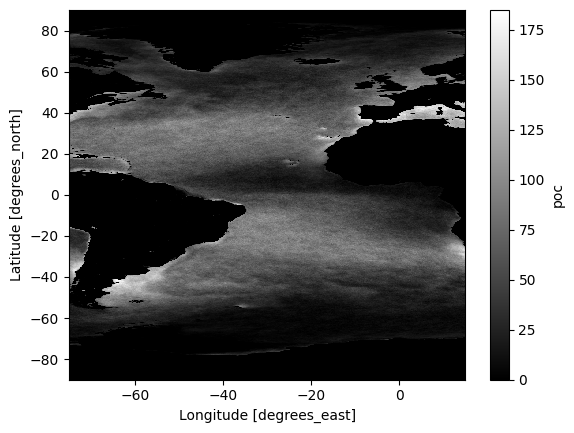

In [56]:
print('max number of datapoints per grid cell ='+str(len(dataset_POC_data.time)))
data_num_POC = dataset_POC_data.notnull().sum(dim='time')
data_num_POC.plot.imshow(cmap='grey')

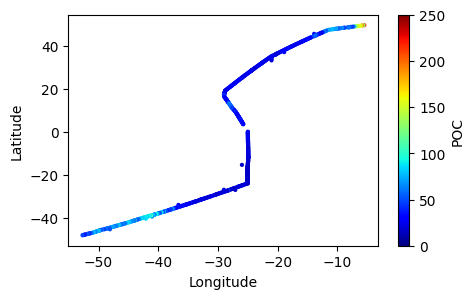

In [682]:
# Read and plot AMT POC data
ds_ATM28 = pd.read_csv('../AMT28_POM.csv')
ds_ATM28['POC'] = ds_ATM28['POC']*12.0
ds_ATM28 = ds_ATM28.where(df.Longitude>-300) # for some reeason there are some strange longitudes, maybe associated with missing data?
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
sc = ds_ATM28.plot.scatter(x='Longitude', y='Latitude', s=4, c='POC',ax=axs,vmin=0,vmax=250,cmap='jet')


In [687]:
# reindex to make it easier to see points on a map
ds_ATM28['POC'] = ds_ATM28['POC'].where(df['POC']<500)
ds_ATM28_2 = ds_ATM28[ds_ATM28.index % 5 == 0] 

/srv/conda/envs/notebook/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1692: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)


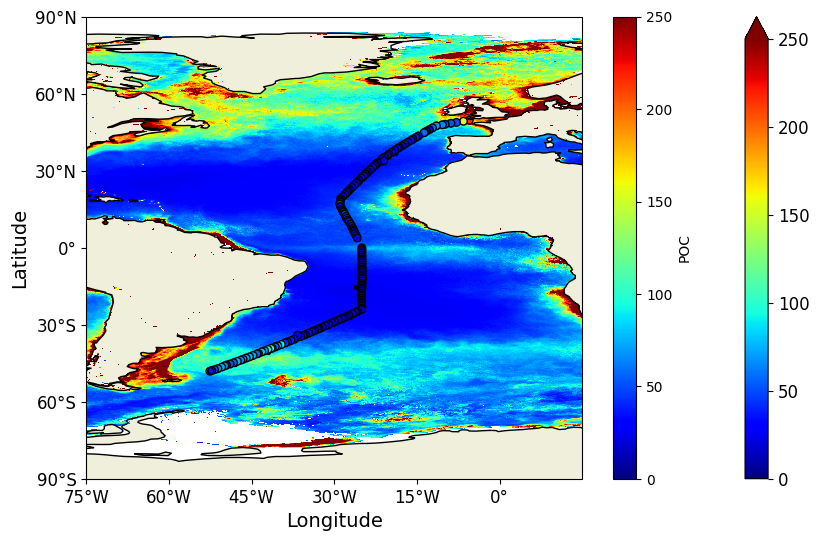

In [688]:
# plot POC with AMD transect
lbs = 12
xyfs = 14
mapn = colors.Normalize(vmin=0, vmax=250)
#colors.LogNorm(vmin=0.001, vmax=0.1)
fig = plt.figure(figsize=(10,6))
axs = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(), aspect='auto')
im=dataset_POC_mean.plot(ax=axs,cmap='jet',norm = mapn,transform=ccrs.PlateCarree())
df.plot.scatter(x='Longitude', y='Latitude', s=8, c='k',ax=axs,vmin=0,vmax=250,cmap='jet')
ds_ATM28_2.plot.scatter(x='Longitude', y='Latitude', s=30, c='POC',edgecolor='k',ax=axs,vmin=0,vmax=250,cmap='jet')
axs.add_feature(cartopy.feature.LAND)
axs.add_feature(cartopy.feature.COASTLINE)
cbar = im.colorbar
cbar.set_label('')
cbar.ax.tick_params(labelsize=lbs)

axs.set_title('')
axs.set_ylabel('Latitude',fontsize=xyfs)
axs.set_xlabel('Longitude',fontsize=xyfs)
axs.set_xticks(np.arange(-75,15,15), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)

axs.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter)
axs.tick_params(axis='both', which='major', labelsize=lbs)
axs.tick_params(axis='both', which='minor', labelsize=lbs)
plt.show()

Compare PACE underway POM to POC

In [14]:
ds_ATM28 = pd.read_csv('../AMT28_POM.csv')
ds_ATM28['POC'] = ds_ATM28['POC']*12.0
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
sc = ds_ATM28.plot.scatter(x='Longitude', y='Latitude', s=4, c='POC',ax=axs,vmin=0,vmax=250,cmap='jet')

In [15]:
df = pd.merge(ds_ATM28.Latitude,ds_ATM28.Longitude,on=ds_ATM28['POM_Sample_No.'])

In [16]:
df['POC'] = ds_ATM28.POC

In [17]:
df['month'] = ds_ATM28.Month
df.month

0       9
1       9
2       9
3       9
4       9
       ..
772    10
773    10
774    10
775    10
776    10
Name: month, Length: 777, dtype: int64

In [18]:
df

,key_0,Latitude,Longitude,POC,month
0,1,49.638,-5.502,17.966,9
1,2,49.581,-5.676,10.450,9
2,3,49.501,-5.908,15.830,9
3,4,49.429,-6.108,12.785,9
4,5,49.355,-6.332,12.995,9
...,...,...,...,...,...
772,773,-48.014,-52.436,2.770,10
773,774,-48.115,-52.572,2.423,10
774,775,-48.115,-52.572,3.328,10
775,776,-48.115,-52.572,NaN,10


In [19]:
df = df.where(df.Longitude>-300) # for some reeason there are some strange longitudes, maybe associated with missing data?

In [20]:
df['POC'] = df['POC']*12.0

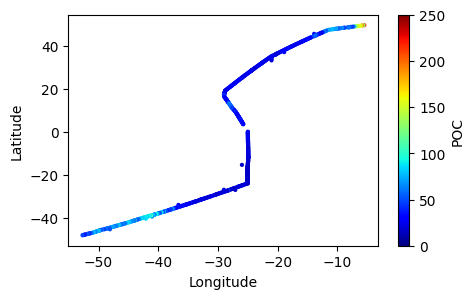

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
sc = df.plot.scatter(x='Longitude', y='Latitude', s=4, c='POC',ax=axs,vmin=0,vmax=250,cmap='jet')

/srv/conda/envs/notebook/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1692: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)


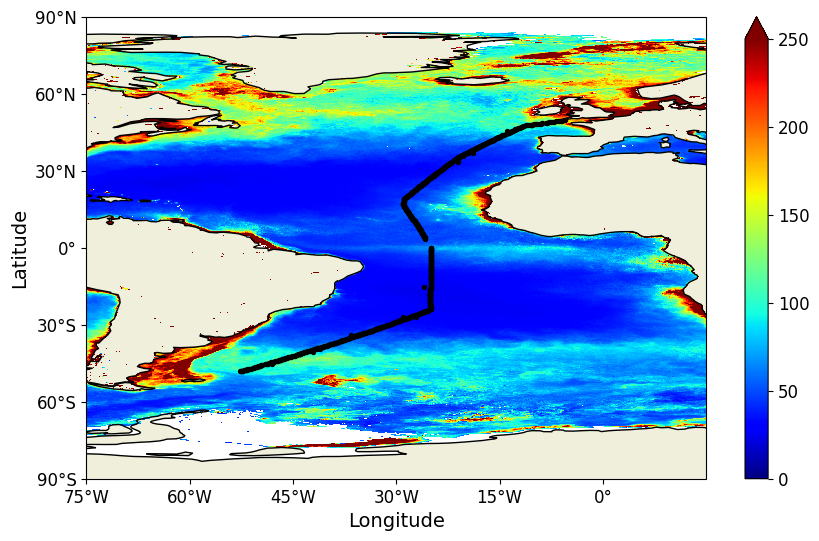

In [685]:
# plot POC and AMT track
lbs = 12
xyfs = 14
mapn = colors.Normalize(vmin=0, vmax=250)
#colors.LogNorm(vmin=0.001, vmax=0.1)
fig = plt.figure(figsize=(10,6))
axs = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(), aspect='auto')
im=dataset_POC_mean.plot(ax=axs,cmap='jet',norm = mapn,transform=ccrs.PlateCarree())
df.plot.scatter(x='Longitude', y='Latitude', s=20, c='POC',edgecolors='black',ax=axs,vmin=0,vmax=250,cmap='jet')
axs.add_feature(cartopy.feature.LAND)
axs.add_feature(cartopy.feature.COASTLINE)
cbar = im.colorbar
cbar.set_label('')
cbar.ax.tick_params(labelsize=lbs)

axs.set_title('')
axs.set_ylabel('Latitude',fontsize=xyfs)
axs.set_xlabel('Longitude',fontsize=xyfs)
axs.set_xticks(np.arange(-75,15,15), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)

axs.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter)
axs.tick_params(axis='both', which='major', labelsize=lbs)
axs.tick_params(axis='both', which='minor', labelsize=lbs)
plt.show()

In [294]:
# function to interpolate PACE to AMT at time that AMT is sampled:
def PACEtoAMT(df,dataset_means,dataset_stds,dataset_medians,v):
  df_PACE = df.copy()
  df_PACE[v] = -9999
  df_PACE[v+'_std'] = -9999
  for j in range(len(df)):
    temp = dataset_means.sel(lat=df.Latitude[j],lon=df.Longitude[j],method='nearest')
    temp_mean = temp.groupby("time.month").mean()
    temp_std = temp.groupby("time.month").std()
    df_PACE[v][j] = temp_mean.sel(month=df.month[j],method='nearest').data
    df_PACE[v+'_std'][j] = temp_std.sel(month=df.month[j],method='nearest').data
  return df_PACE

In [477]:
def PACEtoAMT_season_long(df,dataset_means,dataset_stds,dataset_medians,v):
  temp_tot = []
  temp_std_tot = []
  temp_med_tot = []
  temp_time_tot = []
  Lat_tot = []
  Lon_tot = []

  for j in range(len(df)):
    temp = dataset_means.sel(lat=df.Latitude[j],lon=df.Longitude[j],method='nearest').values
    temp_std = dataset_stds.sel(lat=df.Latitude[j],lon=df.Longitude[j],method='nearest').values
    temp_med = dataset_medians.sel(lat=df.Latitude[j],lon=df.Longitude[j],method='nearest').values
    Lat = np.ones(len(temp))*df['Latitude'][j]
    Lon = np.ones(len(temp))*df['Longitude'][j]
    Lon_tot = np.append(Lon_tot, Lon)
    Lat_tot = np.append(Lat_tot, Lat)
    temp_tot= np.append(temp_tot, temp)
    temp_std_tot = np.append(temp_std_tot, temp_std)
    temp_med_tot= np.append(temp_med_tot, temp_med)
    temp_time = dataset_means.time.dt.strftime('%Y').values + ' '+ dataset_means.time.dt.strftime('%B').values
    temp_time = temp_time.tolist()
    temp_time_tot = temp_time_tot+temp_time
  print(len(temp_time_tot))
  print(len(Lat_tot))
  print(len(Lon_tot))

  d = {'month_year': temp_time_tot, 'Latitude': Lat_tot, 'Longitude': Lon_tot,'mean':temp_tot, 'median': temp_med_tot, 'std': temp_std_tot, 'values': v}
  df = pd.DataFrame(data=d)
    
#    for m in range(len(dataset_means.time)):
#      df_PACE[v+'_mean'][j] = temp.sel(time=temp.time[m]).values
#      df_PACE[v]['month_year'] = temp[m].time.dt.strftime('%Y').values + ' '+ temp[m].time.dt.strftime('%B').values
#      df_PACE[v+'_std'][j] = temp_std.sel(time=temp.time[m]).values
#      df_PACE[v+'_median'][j] = temp_med.sel(time=temp.time[m]).values

  return df

In [478]:
# function to interpolate PACE monthly means to all AMT data:
def PACEtoAMT_season(df,dataset_means,dataset_stds,dataset_medians,v):
  monthly_means = np.nan*np.ones([len(df),len(dataset_means.time)])
  monthly_stds = np.nan*np.ones([len(df),len(dataset_means.time)])
  monthly_medians = np.nan*np.ones([len(df),len(dataset_means.time)])
  for j in range(len(df)):
    temp = dataset_means.sel(lat=df.Latitude[j],lon=df.Longitude[j],method='nearest')
    monthly_means[j,:] = temp.data
    temp = dataset_stds.sel(lat=df.Latitude[j],lon=df.Longitude[j],method='nearest')
    monthly_stds[j,:] = temp.data
    temp = dataset_medians.sel(lat=df.Latitude[j],lon=df.Longitude[j],method='nearest')
    monthly_medians[j,:] = temp.data
  return monthly_means,monthly_stds,monthly_medians

In [479]:
POC_dataframe = PACEtoAMT_season_long(df,POC_monthly_means,POC_monthly_stds,POC_monthly_medians,'POC')

11655
11655
11655


In [480]:
POC_dataframe

,month_year,Latitude,Longitude,mean,median,std,values
0,2024 March,49.638,-5.502,111.000000,111.000000,0.000000,POC
1,2024 April,49.638,-5.502,151.699951,153.500000,21.727484,POC
2,2024 May,49.638,-5.502,262.257050,277.000000,112.619766,POC
3,2024 June,49.638,-5.502,102.054420,105.399902,6.594787,POC
4,2024 July,49.638,-5.502,100.044327,100.199707,4.778481,POC
...,...,...,...,...,...,...,...
11650,2025 January,-48.199,-52.692,91.516518,89.999756,15.407207,POC
11651,2025 February,-48.199,-52.692,70.828545,68.600098,5.345746,POC
11652,2025 March,-48.199,-52.692,91.639938,88.600098,7.534835,POC
11653,2025 April,-48.199,-52.692,77.699951,78.699951,4.570593,POC


In [443]:
POC_dataframe

(array([111.        , 151.69995117, 262.25704956, ...,  91.63993835,
         77.69995117,          nan], shape=(11655,)),
 ['2024 March',
  '2024 April',
  '2024 May',
  '2024 June',
  '2024 July',
  '2024 August',
  '2024 September',
  '2024 October',
  '2024 November',
  '2024 December',
  '2025 January',
  '2025 February',
  '2025 March',
  '2025 April',
  '2025 May',
  '2024 March',
  '2024 April',
  '2024 May',
  '2024 June',
  '2024 July',
  '2024 August',
  '2024 September',
  '2024 October',
  '2024 November',
  '2024 December',
  '2025 January',
  '2025 February',
  '2025 March',
  '2025 April',
  '2025 May',
  '2024 March',
  '2024 April',
  '2024 May',
  '2024 June',
  '2024 July',
  '2024 August',
  '2024 September',
  '2024 October',
  '2024 November',
  '2024 December',
  '2025 January',
  '2025 February',
  '2025 March',
  '2025 April',
  '2025 May',
  '2024 March',
  '2024 April',
  '2024 May',
  '2024 June',
  '2024 July',
  '2024 August',
  '2024 September',
  '2024 

In [328]:
df_POC_PACE = PACEtoAMT_season_long(df,POC_monthly_means,POC_monthly_stds,POC_monthly_medians,'POC')

[111.       151.69995  262.25705  102.05442  100.04433  131.51993
 121.066734 273.03336  101.19971   68.3999    88.2666   139.3999
 193.19984  212.5599          nan]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 15

In [305]:
len(df_POC_PACE)

777

In [227]:
# From Olivia: Storage for output DataFrames. Function works one varibale at a time
def make_df(da_mean,da_std,dat_med,v):
  print(f"Extracting: {v}")
  all_dfs = pd.merge([da_mean,da_std,dat_med], on=['
  all_dfs.append(interp_df)

# Merge all variable DataFrames on date/lat/lon
  final_df = all_dfs[0]
  for df in all_dfs[1:]:
    final_df = final_df.merge(df, on=["date", "Lat", "Lon"])

(777, 12)

In [37]:
df_PACE_POC = PACEtoAMOT(df,dataset_POC_data,'POC')

0 121.066734
1 133.69995
2 192.30005
3 174.95987
4 135.8999
5 122.8999
6 104.69995
7 84.19971
8 99.59985
9 88.99984
10 83.34985
11 97.933266
12 100.30005
13 90.99984
14 102.74988


/tmp/ipykernel_104/97681489.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PACE[v][j] = temp_mean.sel(month=df.month[j],method='nearest').data
/tmp/ipykernel_104/97681489.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PACE[v+'_std'][j] = temp_std.sel(month=df.month[j],method='nearest').data
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Deg

15 102.74988
16 114.0
17 113.46655
18 95.766685
19 83.42215
20 84.279884
21 110.999916
22 104.679886
23 104.679886
24 104.679886
25 108.0
26 107.299805
27 82.19987
28 69.599976
29 72.06657


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

30 73.06657
31 69.1333
32 71.1333
33 57.649902
34 53.833252
35 48.899902
36 48.80005
37 50.049927
38 46.533367
39 53.239845
40 53.239845
41 48.899902
42 54.733234
43 52.839844
44 56.51992
45 53.95996


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

46 55.149902
47 53.114117
48 53.114117
49 53.114117
50 52.7666
51 54.657085
52 55.124878
53 45.47988
54 42.47988
55 54.657085
56 43.228447
57 43.099854
58 43.399902
59 42.359863
60 45.8856
61 43.533203


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


62 41.599888
63 42.11419
64 40.274902
65 39.933186
66 38.933212
67 38.854446
68 38.571358
69 38.399902
70 38.39984
71 40.79997
72 39.19983
73 39.19983
74 39.19983
75 37.32002
76 37.19995
77 38.399902


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


78 40.05706
79 41.1999
80 39.599934
81 39.359863
82 38.950012
83 39.466633
84 42.866535
85 40.299805
86 39.466473
87 38.599976
88 38.999878
89 37.399902
90 36.599934
91 36.319923
92 36.94983
93 37.433186
94 35.249878
95 34.319923
96 34.03994
97 34.14272
98 34.14272
99 34.14272
100 34.774902
101 35.939842
102 35.6888
103 35.15549
104 32.799805
105 34.436302
106 32.977646
107 33.755478
108 32.674866
109 32.375


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


110 32.974915
111 31.799967
112 31.999939
113 31.9428
114 31.57136
115 30.499918
116 30.499918
117 30.856934
118 30.542759
119 31.199902
120 31.999939
121 31.674927
122 31.799967
123 31.953688
124 31.953688
125 31.953688
126 32.436214
127 31.644478
128 32.149902
129 32.02839
130 33.55996
131 32.44439
132 32.688694
133 33.359863
134 32.699852
135 30.955513
136 33.35547
137 32.327236
138 30.177788
139 31.299927
140 28.566488
141 28.566488
142 28.349854
143 30.079784
144 30.52002
145 27.866617
146 27.424927
147 27.433268
148 25.866537
149 25.866537
150 25.866537
151 28.199917
152 28.199917
153 29.249878
154 28.822157
155 27.742815
156 28.054466
157 31.377604
158 27.724976
159 29.899841
160 30.359863
161 30.349976
162 28.9428
163 28.628418
164 28.983236
165 27.236284
166 26.274902
167 26.742815
168 28.1
169 28.244358
170 27.44989
171 28.285574
172 26.349915
173 26.349915
174 26.349915
175 26.349915
176 27.199986
177 28.199884
178 27.799866
179 28.179932
180 27.519922
181 27.679882
182 28.0

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


206 36.666584
207 37.166584
208 38.799927
209 39.711044
210 39.19995
211 40.228516
212 42.94995
213 41.666584
214 40.6
215 39.899902
216 39.899902
217 40.049927
218 38.666504
219 40.049927
220 39.299927
221 39.056988


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

222 39.049927
223 38.999836
224 38.999836
225 38.999836
226 38.733234
227 37.239845
228 38.55996
229 38.533203
230 38.466633
231 36.349976
232 36.19995
233 37.399902
234 37.899902
235 42.879883
236 45.666668
237 42.900024


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

238 44.44995
239 43.80005
240 48.64978
241 48.64978
242 48.599934
243 42.600098
244 44.0
245 44.866535
246 44.866535
247 38.799805
248 41.0
249 41.0
250 41.0
251 42.0


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

252 41.19995
253 44.399902
254 41.866535
255 38.0
256 38.799805
257 41.600098
258 44.0
259 47.5
260 47.5
261 46.20003
262 46.19995
263 49.5
264 nan
265 45.600098
266 45.600098
267 48.899902


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

268 50.80005
269 48.600098
270 51.0
271 50.400066
272 51.06673
273 51.0
274 51.0
275 51.0
276 56.600098
277 59.06657
278 56.599854
279 56.33317
280 58.0
281 54.799805
282 55.733234


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

283 55.466633
284 46.600098
285 49.999756
286 51.100098
287 48.266438
288 49.733234
289 48.899902
290 45.399902
291 45.399902
292 55.0
293 55.600098
294 55.799805
295 48.399902
296 56.799805
297 48.33317


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

298 51.349854
299 51.349854
300 51.349854
301 55.600098
302 47.399902
303 42.899902
304 43.69995
305 47.0
306 47.0
307 43.599854
308 42.93327
309 39.866535
310 38.799805
311 44.399902
312 41.0


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

313 nan
314 38.799805
315 42.866535
316 39.0
317 41.899902
318 42.600098
319 40.549927
320 42.266438
321 40.133137
322 42.679882
323 40.999756
324 40.999756
325 40.999756
326 42.32002
327 40.133137
328 39.93327


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

329 41.93327
330 42.1333
331 nan
332 43.799805
333 42.93327
334 40.899902
335 39.79997
336 40.79997
337 37.199707
338 40.399902
339 39.799805
340 39.733234
341 39.733234
342 40.5
343 43.799805


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

344 43.799805
345 58.849854
346 60.849854
347 61.5
348 61.299805
349 61.94983
350 60.533203
351 69.43994
352 68.06641
353 68.06641
354 68.06641
355 61.649902
356 62.06657
357 53.299805
358 56.92002
359 58.19995


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


360 57.44995
361 55.19987
362 59.0
363 55.399902
364 54.03994
365 51.266438
366 39.399902
367 34.199707
368 46.666668
369 37.0
370 37.0
371 42.69995
372 44.666668
373 41.20003
374 36.399902
375 32.0


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


376 38.333332
377 40.199707
378 40.199707
379 40.199707
380 39.799805
381 40.600098
382 39.2666
383 36.899902
384 37.999756
385 37.19995
386 37.999756
387 36.19987
388 39.69995
389 40.599854
390 46.0
391 45.533367
392 60.0
393 55.299805
394 55.5
395 61.399902
396 61.399902
397 40.19987
398 41.199707
399 33.799805
400 36.399902
401 36.399902
402 34.499756
403 34.499756
404 34.499756
405 36.69995
406 34.599854
407 33.599934
408 32.466633
409 33.0
410 33.599854
411 33.600098
412 34.799805
413 37.399902
414 37.359962
415 35.44983
416 32.399902
417 31.949951
418 32.999756
419 27.699951
420 27.699951
421 29.566568
422 29.799927
423 29.649902
424 30.899902
425 29.599888
426 29.599888
427 29.599888
428 29.599888
429 29.599888
430 29.249878
431 29.171387
432 28.124878
433 29.249878
434 28.571428
435 29.333252
436 25.92002
437 24.733398
438 25.27998
439 25.44983
440 25.0
441 25.359863
442 27.657087
443 25.549927
444 27.699951
445 27.699951
446 26.239843
447 24.866617
448 24.19987
449 26.799967
4

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

537 nan
538 31.679882
539 30.899902
540 30.666504
541 30.33317
542 30.999918
543 30.999918
544 30.999918
545 29.239843
546 30.999878
547 35.166584
548 29.719921
549 29.719921
550 29.719921
551 29.719921


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


552 29.719921
553 32.119923
554 34.149902
555 31.679882
556 32.72002
557 32.599804
558 31.959864
559 32.499878
560 32.599976
561 34.13322
562 32.67998
563 32.600018
564 33.849976
565 32.600098
566 34.866535
567 36.666504
568 36.666504
569 35.79997
570 33.199707
571 37.799805
572 39.600098
573 nan
574 35.51992
575 35.51992
576 35.51992
577 37.2666
578 35.8
579 35.119923
580 36.299805
581 41.91992
582 46.799904
583 44.299927


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


584 46.399982
585 46.94273
586 61.600098
587 53.099854
588 50.499756
589 48.19995
590 46.400024
591 50.333332
592 48.150024
593 48.150024
594 49.666504
595 48.166504
596 44.733234
597 44.67998
598 49.599854
599 49.599854
600 49.599854
601 46.82489
602 46.82489
603 48.399902
604 47.549927
605 48.899822
606 46.466633
607 46.466633
608 55.733234
609 58.499878
610 55.19995
611 61.828472
612 63.4285
613 53.171387
614 51.51416
615 60.124817


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

616 60.124817
617 60.124817
618 63.171318
619 62.624878
620 60.222115
621 58.755535
622 68.29985
623 68.29985
624 68.29985
625 65.58167
626 65.58167
627 73.224915
628 82.95541
629 84.342705
630 54.650024
631 70.64004
632 70.29993
633 56.9999
634 62.099854
635 65.2666
636 79.8667
637 74.19987
638 87.24988
639 94.239845
640 94.239845
641 90.83325
642 131.71982
643 139.97133
644 86.57489
645 80.099976
646 83.266685
647 83.266685


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


648 83.266685
649 83.91413
650 84.04993
651 84.12488
652 80.974915
653 85.92493
654 89.65991
655 92.79985
656 94.07681
657 95.679886
658 98.724915
659 93.99993
660 91.55986
661 92.84429
662 95.59985
663 92.05456


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


664 92.05456
665 93.28879
666 91.771416
667 90.03329
668 101.11419
669 95.82483
670 91.63322
671 95.43984
672 95.43984
673 95.43984
674 100.53329
675 100.53329
676 95.59985
677 90.933266
678 90.25704
679 87.7749
680 87.97485
681 85.47485
682 85.33999
683 86.19992
684 102.666664
685 112.999916
686 122.428505
687 135.54987
688 121.94995
689 145.47491
690 130.88567
691 157.71422
692 174.15544
693 145.86664
694 142.59987
695 142.47989


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

696 143.93321
697 143.93321
698 143.93321
699 151.75
700 151.75
701 133.1499
702 170.83989
703 113.09994
704 105.5332
705 99.85991
706 98.91097
707 97.23999
708 113.724915
709 120.0
710 111.37988
711 112.085655


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


712 122.97126
713 95.77762
714 94.83984
715 102.2889
716 98.44995
717 98.86659
718 95.55991
719 92.13994
720 89.75548
721 91.666504
722 95.51992
723 95.51992
724 95.51992
725 90.279884
726 93.12494
727 93.51102
728 104.499855
729 95.95551
730 99.51416
731 144.54987
732 127.355415
733 147.57764
734 127.199905
735 112.08559
736 85.83984
737 84.166504
738 82.03994
739 110.15981
740 110.15981
741 105.87488
742 80.828476
743 104.24988


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

744 104.11983
745 104.91413
746 104.57136
747 94.19989
748 94.19989
749 94.19989
750 106.19987
751 104.5332
752 108.14984
753 110.86654
754 116.63994
755 98.39983
756 101.06657
757 96.42857
758 98.83994
759 90.51992


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

760 91.83317
761 88.35986
762 98.11992
763 96.95996
764 90.11992
765 95.29993
766 95.29993
767 111.239845
768 140.35995
769 142.24988
770 124.54993
771 108.69995
772 120.239944
773 98.96664
774 98.96664
775 98.96664
776 96.25704


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

In [147]:
df_PACE_cphyto = PACEtoAMOT(df,dataset_cphyto_data,'cphyto')

0 28.87026
1 32.59581
2 30.752768
3 29.05103
4 22.953785
5 25.125973
6 35.859444
7 33.106007
8 36.106453
9 24.712729
10 24.0225
11 23.828773
12 21.761269
13 19.457027
14 21.215014
15 21.215014


/tmp/ipykernel_104/97681489.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PACE[v][j] = temp_mean.sel(month=df.month[j],method='nearest').data
/tmp/ipykernel_104/97681489.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PACE[v+'_std'][j] = temp_std.sel(month=df.month[j],method='nearest').data
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Deg

16 18.690752
17 25.077612
18 19.288454
19 22.4493
20 19.999151
21 25.696594
22 24.525364
23 24.525364
24 24.525364
25 22.007772
26 20.947226
27 24.580515
28 17.9767
29 17.279327
30 15.109421
31 16.246061


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

32 17.750551
33 18.962797
34 23.905266
35 11.824062
36 11.531343
37 15.470703
38 13.710026
39 12.421277
40 12.421277
41 12.505799
42 14.698009
43 13.109873
44 17.254261
45 18.967335
46 17.843319
47 16.979822


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

48 16.979822
49 16.979822
50 17.423628
51 16.123234
52 15.465837
53 13.128149
54 15.960276
55 16.123234
56 17.924719
57 13.428549
58 14.176369
59 14.283865
60 16.272772
61 16.329506
62 15.888104
63 15.367357


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


64 15.1732235
65 14.468018
66 16.602465
67 16.445093
68 16.38602
69 15.873049
70 15.4467
71 17.309027
72 15.492594
73 15.492594
74 15.492594
75 15.005056
76 16.610453
77 17.747614
78 17.703892
79 24.232172


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


80 21.15264
81 21.39924
82 20.774088
83 18.414213
84 22.406359
85 17.779987
86 19.007559
87 18.35684
88 17.23344
89 17.247545
90 16.706535
91 19.322693
92 18.850494
93 21.944986
94 18.297152
95 16.277029
96 15.177602
97 17.678831
98 17.678831
99 17.678831
100 18.165653
101 18.867292
102 20.386284
103 18.462938
104 17.177837
105 16.856539
106 16.759542
107 17.857765
108 17.953445
109 17.746801
110 18.17091
111 16.152292


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


112 17.000153
113 16.462912
114 15.658983
115 14.061637
116 14.061637
117 14.183473
118 14.67287
119 16.736675
120 18.25077
121 17.138086
122 18.101643
123 18.41278
124 18.41278
125 18.41278
126 17.028374
127 16.257954
128 16.747713
129 17.300468
130 18.950039
131 17.429483
132 16.84637
133 18.339087
134 17.533108
135 15.87413
136 18.228518
137 17.348011
138 15.806283
139 17.5152
140 15.109531
141 15.109531
142 15.035181
143 16.270222
144 18.442646
145 15.430665
146 13.646052
147 13.5945425
148 10.645301
149 10.645301
150 10.645301
151 15.673318
152 15.673318
153 15.039626
154 16.852577
155 15.574382
156 14.612738
157 16.15119
158 14.289104
159 17.46203
160 17.315609
161 18.130205
162 15.709252
163 16.961174
164 16.71448
165 14.753445
166 14.028044
167 14.097404
168 17.148752
169 17.096338
170 17.231924
171 17.9511
172 16.507622
173 16.507622
174 16.507622
175 16.507622
176 17.254906
177 17.778368
178 16.723293
179 16.90537
180 15.034845
181 16.455551
182 16.783646
183 15.009223
184 16

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


207 19.789505
208 20.285929
209 19.63889
210 18.715853
211 20.668047
212 22.934715
213 23.51275
214 19.692505
215 20.76161
216 20.76161
217 22.137993
218 19.562502
219 22.137993
220 21.642181
221 20.16469
222 20.435127


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

223 19.45479
224 19.45479
225 19.45479
226 16.819933
227 14.977719
228 19.304274
229 15.892586
230 15.269345
231 17.66132
232 18.00887
233 19.775702
234 17.053429
235 17.845488
236 18.06542
237 17.228535
238 16.688595


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

239 16.202385
240 20.148485
241 20.148485
242 20.07998
243 21.331606
244 17.117897
245 19.054506
246 19.054506
247 14.04303
248 20.255564
249 20.255564
250 20.255564
251 19.974833
252 14.585455
253 17.555208
254 14.725789


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

255 18.616844
256 17.80954
257 20.068195
258 22.806898
259 18.124218
260 21.920399
261 17.65523
262 21.833702
263 19.00026
264 nan
265 11.46658
266 11.46658
267 22.307268
268 22.825493
269 16.773424


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

270 16.612371
271 24.564684
272 19.599625
273 21.091043
274 21.091043
275 21.091043
276 22.3988
277 19.954927
278 16.435257
279 20.315786
280 21.622307
281 21.427763
282 20.385626
283 10.712006
284 13.914254
285 14.830229


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

286 19.877548
287 18.278057
288 20.98349
289 18.034067
290 18.130041
291 18.130041
292 30.123684
293 29.901049
294 23.793633
295 15.944311
296 21.324621
297 19.155611
298 22.58994
299 22.58994
300 22.58994
301 20.57367


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

302 20.002346
303 19.526531
304 22.612488
305 11.730792
306 11.730792
307 12.543064
308 16.809153
309 17.22836
310 14.614243
311 21.268028
312 19.532072
313 nan
314 16.08799
315 22.351006
316 17.496902


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

317 19.738297
318 22.395725
319 19.851479
320 21.645302
321 18.834686
322 23.235697
323 17.830948
324 17.830948
325 17.830948
326 22.762497
327 16.919304
328 17.862955
329 20.766127
330 23.095945
331 nan


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

332 21.858345
333 19.346834
334 24.920464
335 18.769043
336 19.299688
337 16.095932
338 20.849232
339 21.23365
340 20.948809
341 20.948809
342 21.23623
343 28.05927
344 28.05927
345 22.981659
346 23.240044
347 21.017876


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

348 21.551819
349 21.055794
350 24.261126
351 26.445114
352 22.409904
353 22.409904
354 22.409904
355 23.057503
356 21.235895
357 15.995276
358 19.559193
359 19.551033
360 18.592432
361 20.541227
362 21.706182
363 16.775513


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


364 18.902569
365 15.145047
366 15.198884
367 11.641391
368 21.28315
369 18.439053
370 18.439053
371 24.456448
372 23.859629
373 21.777632
374 17.600616
375 14.256649
376 20.988592
377 20.652332
378 20.652332
379 20.652332


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


380 19.315731
381 19.752665
382 21.3814
383 18.716148
384 19.455715
385 18.566563
386 19.24432
387 20.060743
388 23.605629
389 25.100838
390 26.929678
391 25.402388
392 30.191715
393 30.073559
394 30.734367
395 31.358139
396 31.358139
397 24.307968
398 20.3786
399 20.227385
400 22.598106
401 23.267796
402 23.986334
403 23.986334
404 23.986334
405 23.258682
406 20.183865
407 20.72922
408 20.322617
409 20.699982
410 21.837135
411 21.875814
412 23.1997
413 20.203484
414 23.365828
415 21.640284
416 19.002632
417 20.011044
418 22.139233
419 15.887413
420 15.887413
421 19.465063
422 21.253004
423 18.75452
424 20.538761
425 20.389227
426 20.389227
427 20.389227
428 20.389227
429 20.389227
430 20.077682
431 19.23088
432 17.925787
433 20.077682
434 20.963148
435 21.854742
436 16.814253
437 15.539989
438 17.433811
439 17.811356
440 16.37668
441 18.783985
442 21.101925
443 20.36737
444 23.837934
445 23.837934
446 20.22596
447 18.866629
448 18.062819
449 20.99447
450 15.372127
451 19.83979
452 20.

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

523 16.141846
524 17.142395
525 14.873844
526 14.873844
527 14.873844
528 14.865941
529 14.573074
530 14.336439
531 14.382786
532 16.932394
533 18.710016
534 16.580301
535 15.844792
536 15.24972
537 nan
538 16.916016
539 16.172722
540 15.732048
541 13.963006
542 15.264993
543 15.264993
544 15.264993
545 12.880264
546 15.451636
547 18.919493
548 13.324664
549 13.324664
550 13.324664
551 13.324664
552 13.324664
553 15.758539


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


554 18.68697
555 14.914537
556 15.393229
557 15.222143
558 15.369472
559 15.637882
560 16.616936
561 17.356897
562 15.242149
563 15.970225
564 16.906647
565 16.867943
566 18.648903
567 19.621635
568 19.621635
569 18.743254
570 10.604233
571 18.478558
572 21.356895
573 nan
574 17.372528
575 17.372528
576 17.372528
577 14.810829
578 14.657758
579 13.279547
580 14.082912
581 17.400494
582 23.36723
583 18.363184
584 20.086382


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


585 20.451933
586 28.705687
587 31.09085
588 25.250961
589 24.087479
590 24.442642
591 25.001318
592 23.461798
593 23.461798
594 28.58229
595 25.038157
596 22.154753
597 21.552277
598 19.812496
599 19.812496
600 19.812496
601 20.739485
602 20.739485
603 21.221102
604 24.847683
605 21.903463
606 22.015055
607 22.015055
608 24.91826
609 31.115349
610 25.275766
611 30.929089
612 32.503227
613 22.943655
614 22.331882
615 25.623049
616 25.623049


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

617 25.623049
618 25.475473
619 26.678656
620 25.70837
621 22.2544
622 28.15588
623 28.15588
624 28.15588
625 28.196466
626 28.196466
627 28.874659
628 28.534079
629 34.482765
630 29.849089
631 36.374928
632 33.15914
633 27.855835
634 25.257755
635 31.058603
636 24.942
637 19.902342
638 26.450771
639 23.457932
640 23.457932
641 27.450699
642 30.872766
643 31.190142
644 27.264612
645 25.584393
646 22.186998
647 22.186998
648 22.186998
649 22.094692
650 21.903095


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


651 24.352783
652 21.42723
653 22.942656
654 26.169739
655 24.725636
656 25.983976
657 23.13091
658 22.67171
659 21.606613
660 19.52098
661 22.402544
662 23.301016
663 23.787464
664 23.787464
665 21.562107
666 20.69596
667 19.43213


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


668 21.81744
669 21.994827
670 21.035255
671 22.614767
672 22.614767
673 22.614767
674 24.907026
675 24.907026
676 23.279703
677 25.331665
678 23.472324
679 22.550667
680 21.702084
681 19.787148
682 23.280207
683 20.042564
684 24.900776
685 27.702372
686 29.471909
687 32.051285
688 28.086235
689 34.761696
690 28.685501
691 35.566204
692 41.16683
693 35.288673
694 36.560387
695 38.669075
696 37.76492
697 37.76492
698 37.76492
699 38.805195
700 38.805195
701 33.323524


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

702 41.237103
703 28.750982
704 27.185377
705 26.09876
706 25.915937
707 28.040638
708 28.627975
709 29.204193
710 27.777155
711 26.771711
712 27.659729
713 20.742653
714 18.604605
715 19.18439
716 16.548504
717 18.649073
718 19.082577


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


719 18.688362
720 17.77434
721 19.10574
722 20.64801
723 20.64801
724 20.64801
725 19.973053
726 21.1594
727 21.436386
728 23.753532
729 23.377403
730 24.081526
731 30.450497
732 29.345045
733 32.824673
734 30.637913
735 25.94404
736 18.814137
737 17.400711
738 16.497272
739 22.949503
740 22.949503
741 22.436745
742 17.212633
743 22.71972
744 21.36899
745 20.332106
746 18.74527
747 19.820375
748 19.820375
749 19.820375
750 16.765627
751 17.329071
752 19.617374


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

753 16.655443
754 17.833422
755 20.634958
756 20.683676
757 20.018671
758 20.781528
759 17.33825
760 19.17822
761 18.258038
762 18.753826
763 18.119991
764 16.504436
765 18.904758
766 18.904758
767 22.202389
768 23.301163
769 22.87835


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

770 25.64332
771 26.972383
772 29.341167
773 27.65615
774 27.65615
775 27.65615
776 27.526134


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [142]:
# some postprocessing
df['POC'] = df['POC'].where(df['POC']<500)
df_PACE_POC2 = df_PACE_POC[df_PACE_POC.index % 3 == 0] 
df2 = df[df.index % 3 == 0] 
df_PACE_cphyto2 = df_PACE_cphyto[df_PACE_cphyto.index % 3 == 0] 

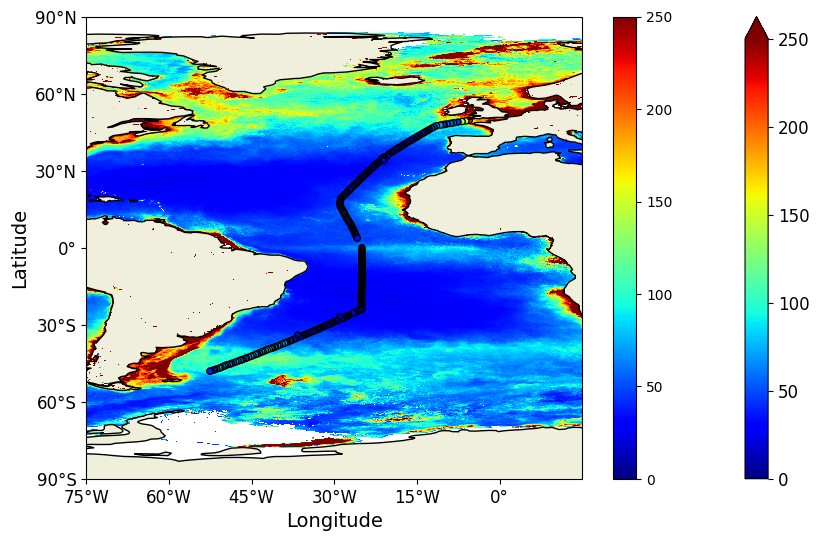

In [39]:
# plot POC from PACE, both mapped and on AMT track
lbs = 12
xyfs = 14
mapn = colors.Normalize(vmin=0, vmax=250)
#colors.LogNorm(vmin=0.001, vmax=0.1)
fig = plt.figure(figsize=(10,6))
axs = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(), aspect='auto')
im=dataset_POC_mean.plot(ax=axs,cmap='jet',norm = mapn,transform=ccrs.PlateCarree())
df2.plot.scatter(x='Longitude', y='Latitude', s=20, c=df2['POC'],edgecolors='black',ax=axs,vmin=0,vmax=250,cmap='jet')
#df_PACE_POC2.plot.scatter(x='Longitude', y='Latitude', s=20, c=df_PACE_POC2['POC'],edgecolors='black',ax=axs,vmin=0,vmax=250,cmap='jet')
axs.add_feature(cartopy.feature.LAND)
axs.add_feature(cartopy.feature.COASTLINE)
cbar = im.colorbar
cbar.set_label('')
cbar.ax.tick_params(labelsize=lbs)

axs.set_title('')
axs.set_ylabel('Latitude',fontsize=xyfs)
axs.set_xlabel('Longitude',fontsize=xyfs)
axs.set_xticks(np.arange(-75,15,15), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)

axs.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter)
axs.tick_params(axis='both', which='major', labelsize=lbs)
axs.tick_params(axis='both', which='minor', labelsize=lbs)
plt.show()

In [40]:
months_true = df['month'].unique()
months_true =months_true[~np.isnan(months_true)]
'months =' + str(months_true.astype(int))

'months =[ 9 10]'

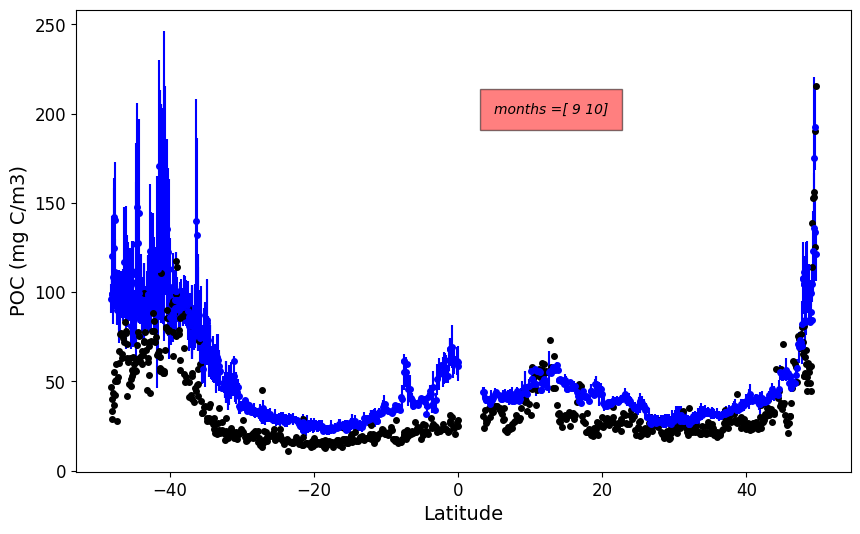

In [41]:
# Now plot latitdue vs. POC for PACE and AMT
lbs = 12
xyfs = 14
mapn = colors.Normalize(vmin=0, vmax=250)
#colors.LogNorm(vmin=0.001, vmax=0.1)
fig = plt.figure(figsize=(10,6))
axs = fig.add_subplot(1,1,1)
axs.errorbar(x=df['Latitude'], y=df['POC'] , fmt="o", color='k', ms=4)
axs.errorbar(x=df_PACE_POC['Latitude'], y=df_PACE_POC['POC'] ,yerr=df_PACE_POC['POC_std'] , fmt="o", color='b', ms=4)
#df_PACE_POC2.plot.scatter(x='Latitude', y='POC', s=8, c='b',ax=axs)

axs.set_title('')
axs.set_ylabel('POC (mg C/m3)',fontsize=xyfs)
axs.set_xlabel('Latitude',fontsize=xyfs)

axs.tick_params(axis='both', which='major', labelsize=lbs)
axs.tick_params(axis='both', which='minor', labelsize=lbs)
axs.text(5, 200, 'months =' +str(months_true.astype(int)), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.show()

In [150]:
# Constant offset---not sure why, but maybe we can try standardization?
def zscore(df,v):
  df[v+'_zscore'] = (df[v] - df[v].mean())/df[v].std()
  return df
def zscore_PACE(df_PACE,v):
  df_PACE[v+'_zscore'] = (df_PACE[v] - df_PACE[v].mean())/df_PACE[v].std()
  df_PACE[v+'_zscore_std'] = abs((df_PACE[v+'_std'] - df_PACE[v+'_std'].mean())/df_PACE[v+'_std'].std())
  return df_PACE

In [151]:
df = zscore(df,'POC')
df_PACE_POC = zscore_PACE(df_PACE_POC,'POC')
df_PACE_cphyto = zscore_PACE(df_PACE_cphyto,'cphyto')

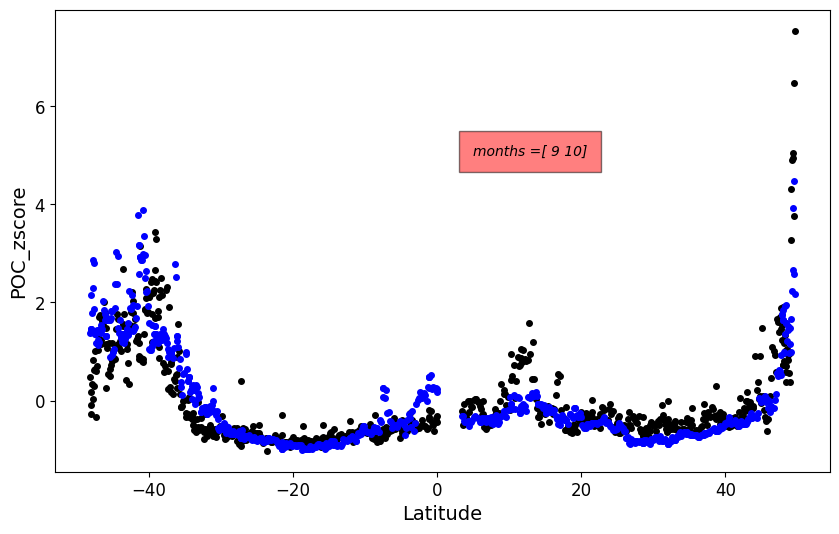

In [114]:
lbs = 12
xyfs = 14
mapn = colors.Normalize(vmin=0, vmax=250)
#colors.LogNorm(vmin=0.001, vmax=0.1)
fig = plt.figure(figsize=(10,6))
axs = fig.add_subplot(1,1,1)
axs.errorbar(x=df['Latitude'], y=df['POC_zscore'] , fmt="o", color='k', ms=4)
axs.errorbar(x=df_PACE_POC['Latitude'], y=df_PACE_POC['POC_zscore'] , fmt="o", color='b', ms=4)

axs.set_title('')
axs.set_ylabel('POC_zscore',fontsize=xyfs)
axs.set_xlabel('Latitude',fontsize=xyfs)
lon_formatter = cticker.LongitudeFormatter()

axs.tick_params(axis='both', which='major', labelsize=lbs)
axs.tick_params(axis='both', which='minor', labelsize=lbs)
axs.tick_params(axis='both', which='major', labelsize=lbs)
axs.tick_params(axis='both', which='minor', labelsize=lbs)
axs.text(5, 5, 'months =' +str(months_true.astype(int)), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.show()

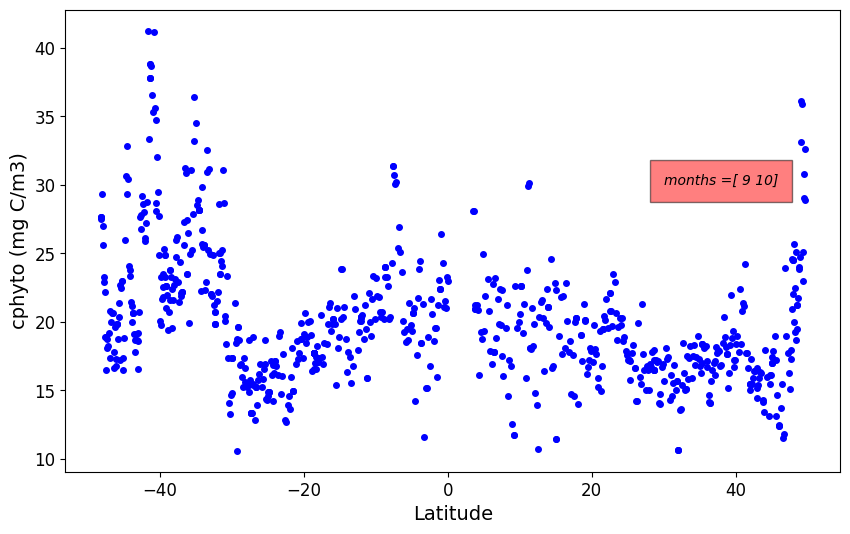

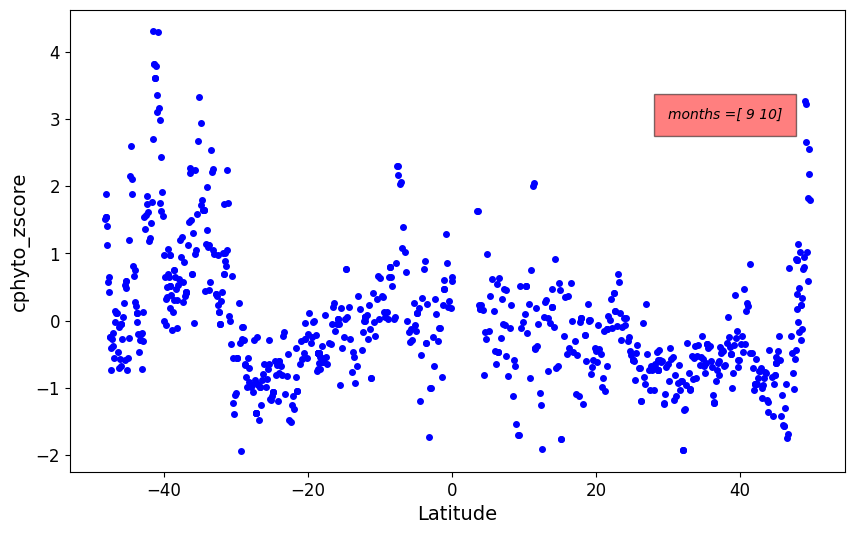

In [161]:
# make the same plot but for only PACE cphyto

lbs = 12
xyfs = 14
#colors.LogNorm(vmin=0.001, vmax=0.1)
fig = plt.figure(figsize=(10,6))
axs = fig.add_subplot(1,1,1)
axs.errorbar(x=df_PACE_cphyto['Latitude'], y=df_PACE_cphyto['cphyto'] , fmt="o", color='b', ms=4)

axs.set_title('')
axs.set_ylabel('cphyto (mg C/m3)',fontsize=xyfs)
axs.set_xlabel('Latitude',fontsize=xyfs)
lon_formatter = cticker.LongitudeFormatter()

axs.tick_params(axis='both', which='major', labelsize=lbs)
axs.tick_params(axis='both', which='minor', labelsize=lbs)
axs.tick_params(axis='both', which='major', labelsize=lbs)
axs.tick_params(axis='both', which='minor', labelsize=lbs)
axs.text(30, 30, 'months =' +str(months_true.astype(int)), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.show()

lbs = 12
xyfs = 14
mapn = colors.Normalize(vmin=0, vmax=250)
#colors.LogNorm(vmin=0.001, vmax=0.1)
fig = plt.figure(figsize=(10,6))
axs = fig.add_subplot(1,1,1)
axs.errorbar(x=df_PACE_cphyto['Latitude'], y=df_PACE_cphyto['cphyto_zscore'] , fmt="o", color='b', ms=4)

axs.set_title('')
axs.set_ylabel('cphyto_zscore',fontsize=xyfs)
axs.set_xlabel('Latitude',fontsize=xyfs)
lon_formatter = cticker.LongitudeFormatter()

axs.tick_params(axis='both', which='major', labelsize=lbs)
axs.tick_params(axis='both', which='minor', labelsize=lbs)
axs.tick_params(axis='both', which='major', labelsize=lbs)
axs.tick_params(axis='both', which='minor', labelsize=lbs)
axs.text(30, 3, 'months =' +str(months_true.astype(int)), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.show()

In [107]:
# correlate 2 variables against each other and provide reg. stats.
def lin_regress(df1,df2,v):
  model = LinearRegression()
# need to remove NaNs
  df1 = df1[df2['POC'].notna()]
  df2 = df2[df2['POC'].notna()]
  df2 = df2[df1['POC'].notna()]
  df1 = df1[df1['POC'].notna()]
  model.fit(df1[v].values.reshape(-1, 1), df2[v].values.reshape(-1, 1))
  r2 = model.score(df1[v].values.reshape(-1, 1),df2[v].values.reshape(-1, 1))
  coefficients = model.coef_
  intercept = model.intercept_
  fig = plt.figure(figsize=(10,6))
  axs = fig.add_subplot(1,1,1)
  axs.errorbar(x=df1[v], y=df2[v] ,xerr=df1[v+'_std'], fmt="o", color='k', ms=4)
  axs.plot(df1[v], intercept+coefficients[0]*df1[v], color="black", lw=1.5)

  axs.set_title('')
  axs.set_ylabel(v+' AMT',fontsize=xyfs)
  axs.set_xlabel(v+' PACE',fontsize=xyfs)

  axs.tick_params(axis='both', which='major', labelsize=lbs)
  axs.tick_params(axis='both', which='minor', labelsize=lbs)
# Add the parameters
  beta0 = r'$intercept = \hat\beta_0 =$' + str(round(intercept[0],2))
  axs.text(df1[v].min(), df2[v].max(), beta0, fontsize=10)

  beta1 = r'$slope = \hat\beta_1 =$' + str(round(coefficients[0][0],2))
  axs.text(df1[v].min(), df2[v].max()-df2[v].max()/8, beta1, fontsize=10)

  r_squared = r'$R^2 =$' + str(round(r2,2))
  axs.text(df1[v].min(), df2[v].max()-df2[v].max()/4,r_squared, fontsize=10)
  plt.show()

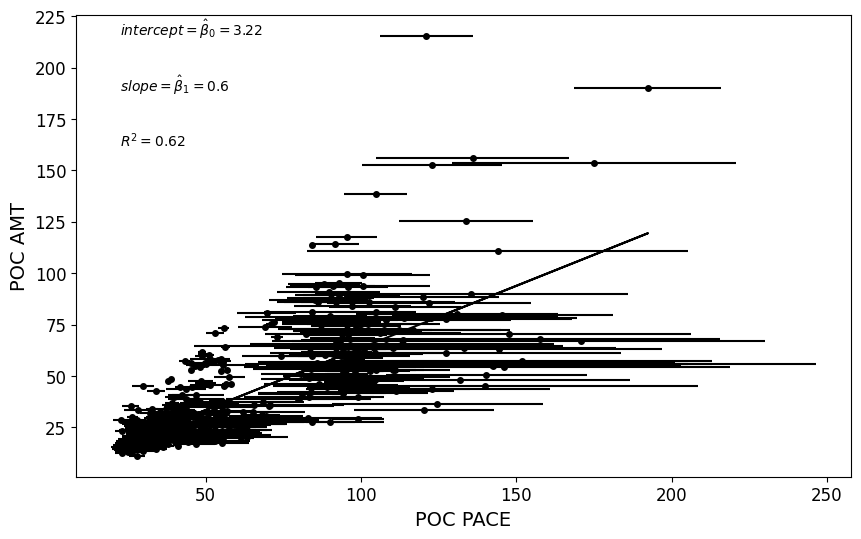

In [108]:
lin_regress(df_PACE_POC,df,'POC')

In [109]:
# maybe we need to remove large POC vlalues?

df_PACE_POC_sm = df_PACE_POC.where(df_PACE_POC['POC']<50)
df_sm = df.where(df['POC']<50)


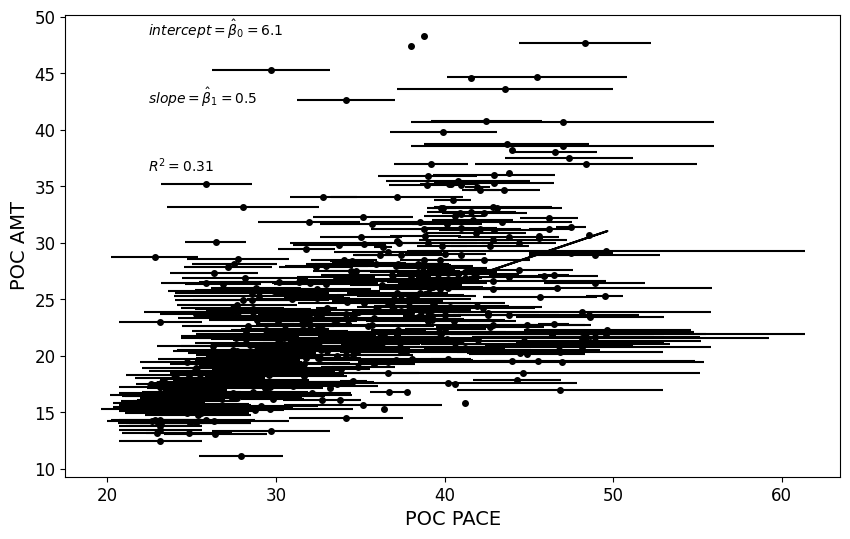

In [110]:
lin_regress(df_PACE_POC_sm,df_sm,'POC')

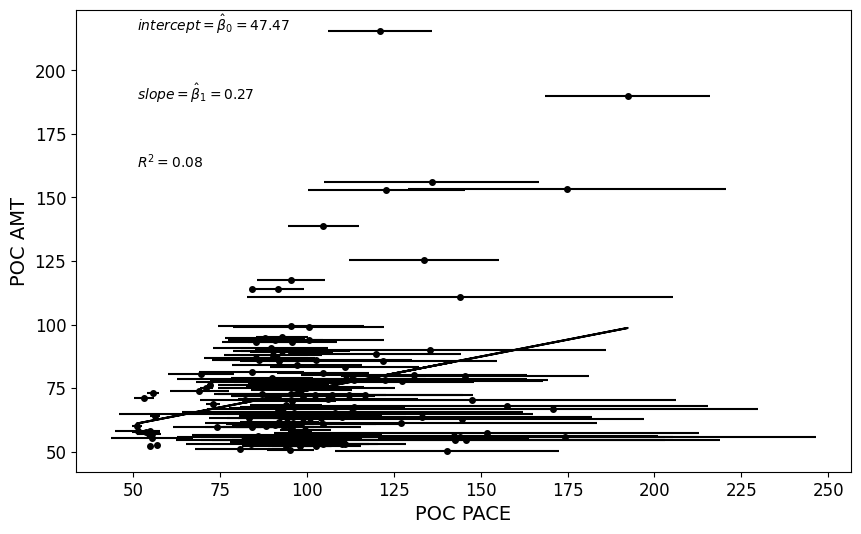

In [117]:
# what about larger POC conc.
df_PACE_POC_lm = df_PACE_POC.where(df_PACE_POC['POC']>50)
df_lm = df.where(df['POC']>50)
lin_regress(df_PACE_POC_lm,df_lm,'POC')

In [162]:
# Now let's make a table for the PACE data the overlay the AMT track